### Visualize the temporal prototype

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
from torch.utils.data import DataLoader
from cmehr.paths import *
from cmehr.dataset.mimic4_datamodule import MIMIC4DataModule

datamodule = MIMIC4DataModule(
    file_path=str(ROOT_PATH / "output_mimic4/ihm"),
    tt_max=48
)
batch = dict()
for batch in datamodule.val_dataloader():
    break
for k, v in batch.items():
    print(f"{k}: ", v.shape)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


FileNotFoundError: [Errno 2] No such file or directory: '/home/*/Documents/EHR_codebase/MMMSPG/src/output_mimic4/ihm/val_p2x_data.pkl'

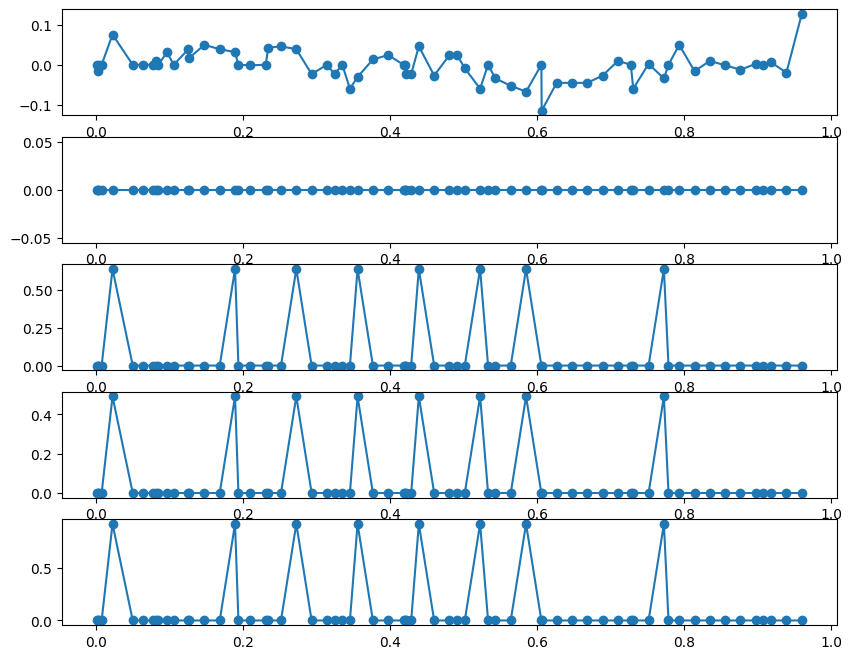

In [35]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(10, 8))

indices = [0, 1, 2, 3, 4]
ts = batch["ts_tt"][0].numpy()
ireg_ts = batch["ts"][0].numpy()

ts_mask = ts != 0
ts = ts[ts_mask]
ireg_ts = ireg_ts[ts_mask]

for i in range(5):
    axes[i].plot(
        ts,
        ireg_ts[:, indices[i]], 
        marker="o",
        )
    # axes[i].set_axis_off()

# for ax in axes:
#     ax.set_xticks([])
#     ax.set_yticks([])

In [3]:
mask = batch["ts_mask"][0].numpy()
plt.imshow(mask.T, aspect="auto")
# plt.grid()
plt.colorbar()

KeyError: 'ts_mask'

In [3]:
from cmehr.models.mimic4 import ProtoTSModel, IPNetModule, GRUDModule, SEFTModule, MTANDModule, DGM2OModule

ckpt_path = "/home/**/Documents/CM-EHR/log/ckpts/mimic4_ihm_2024-02-28_23-46-10/epoch=7-step=1080.ckpt"
model = ProtoTSModel.load_from_checkpoint(ckpt_path, 
                                          map_location="cpu", 
                                        #   mixup_level="batch", 
                                        #   task="pheno",
                                        #   period_length=24
                                          )

FileNotFoundError: [Errno 2] No such file or directory: '/home/**/Documents/CM-EHR/log/ckpts/mimic4_ihm_2024-02-28_23-46-10/epoch=7-step=1080.ckpt'

In [ ]:
import torch
from einops import rearrange

x_ts = batch["ts"]
x_ts_mask = batch["ts_mask"]
ts_tt_list = batch["ts_tt"]
reg_ts = batch["reg_ts"]

proj_x_ts_irg = model.forward_ts_mtand(
    x_ts, x_ts_mask, ts_tt_list)
assert reg_ts != None
proj_x_ts_reg = model.forward_ts_reg(reg_ts)
# 42, 4, 128
proj_x_ts = model.gate_ts(proj_x_ts_irg, proj_x_ts_reg)
batch_size = proj_x_ts.size(0)
proj_x_ts = rearrange(proj_x_ts, "tt b d -> b d tt")
slot_loss = 0.

if not model.use_multiscale:
    ts_feat = model.proj_multi_scale_ts[0](proj_x_ts)
    if model.use_prototype:
        ts_feat = rearrange(ts_feat, "b d tt -> b tt d")
        pe = model.pe(ts_feat)
        ts_pe = ts_feat + pe
        updates, attn = model.grouping[0](ts_pe)
        slot_loss += torch.mean(attn)
        last_ts_feat = torch.cat([updates, ts_feat], dim=1)
    else:
        last_ts_feat = rearrange(ts_feat, "b d tt -> b tt d")
else:
    # proj_x_ts = rearrange(proj_x_ts, "tt b d -> b d tt")
    multi_scale_feats = []
    multi_attn = []
    if model.use_prototype:
        for idx, proj_ts in enumerate(model.proj_multi_scale_ts):
            # extract the feature in each window
            ts_feat = proj_ts(proj_x_ts)
            ts_feat = rearrange(ts_feat, "b d tt -> b tt d")
            pe = model.pe(ts_feat)
            ts_pe = ts_feat + pe
            updates, attn = model.grouping[idx](ts_pe)
            slot_loss += torch.mean(attn)
            multi_scale_feats.append(updates)
            multi_scale_feats.append(ts_feat)
            multi_attn.append(attn)

In [ ]:
reg_ts[0].std(dim=0).topk(5)

torch.return_types.topk(
values=tensor([0.4376, 0.4104, 0.3766, 0.3766, 0.3766]),
indices=tensor([20, 27, 18, 19, 17]))

In [ ]:
import json
file_path = "/home/**/Documents/CM-EHR/cmehr/resources/mimic4/discretizer_config.json"
with open(file_path, "r") as f:
    discretizer_config = json.load(f)

variables = discretizer_config["id_to_channel"]

In [ ]:
variables

['Diastolic blood pressure',
 'Fraction inspired oxygen',
 'Glascow coma scale eye opening',
 'Glascow coma scale motor response',
 'Glascow coma scale verbal response',
 'Glucose',
 'Heart Rate',
 'Height',
 'Mean blood pressure',
 'Oxygen saturation',
 'Respiratory rate',
 'Systolic blood pressure',
 'Temperature',
 'Weight',
 'pH']

Diastolic blood pressure
Glucose
Heart Rate
Mean blood pressure
Oxygen saturation


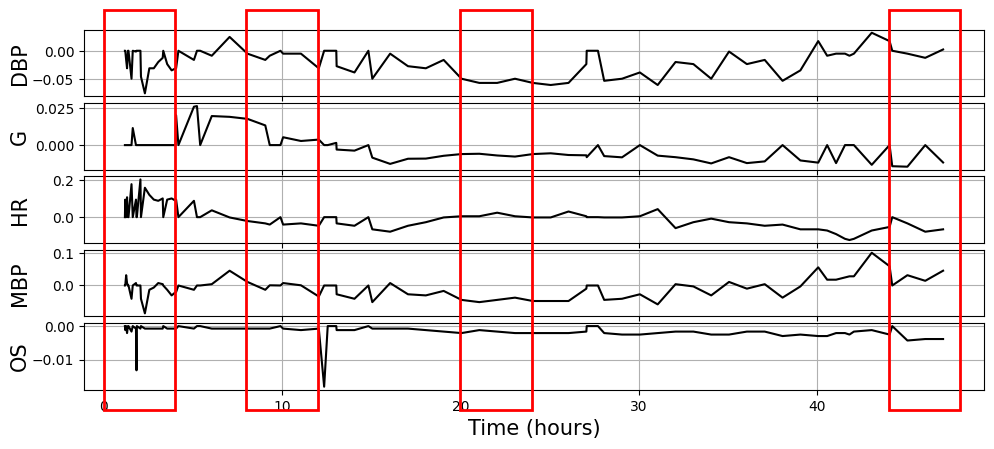

In [ ]:
idx = 3
columns = [
    "DBP", "G", "HR", "MBP", "OS"
]
mask = ts_tt_list[idx] != 0
# feature_indices = x_ts[idx].std(dim=0).topk(5).indices
feature_indices = [0, 5, 6, 8, 9]
import matplotlib.pyplot as plt
fig, axes = plt.subplots(5, 1)
fig.set_figwidth(10)
fig.set_figheight(4)
for r_i, i in enumerate(feature_indices):
    axes[r_i].plot(ts_tt_list[idx][mask] * 48, x_ts[idx][mask, i], color="black")
    axes[r_i].grid()
    axes[r_i].set_ylabel(columns[r_i], fontsize=15)
    axes[r_i].get_yaxis().set_label_coords(-0.06, 0.5)
    print(variables[i])

axes[4].set_xlabel("Time (hours)", fontsize=15)

plt.subplots_adjust(
    top=0.95, bottom=0.05, left=0.05,
    right=0.95,
    wspace=0.15, hspace=0.1)

xmin, xmax = 0, 4
import matplotlib
trans = matplotlib.transforms.blended_transform_factory(axes[0].transData, fig.transFigure)
r = matplotlib.patches.Rectangle(xy=(xmin,0), width=xmax-xmin, height=1, transform=trans,
                                 fc='none', ec='r', lw=2)
fig.add_artist(r)

xmin, xmax = 8, 12
trans = matplotlib.transforms.blended_transform_factory(
    axes[0].transData, fig.transFigure)
r = matplotlib.patches.Rectangle(xy=(xmin, 0), width=xmax-xmin, height=1, transform=trans,
                                 fc='none', ec='r', lw=2)
fig.add_artist(r)


xmin, xmax = 20, 24
trans = matplotlib.transforms.blended_transform_factory(
    axes[0].transData, fig.transFigure)
r = matplotlib.patches.Rectangle(xy=(xmin, 0), width=xmax-xmin, height=1, transform=trans,
                                 fc='none', ec='r', lw=2)
fig.add_artist(r)

xmin, xmax = 44, 48
trans = matplotlib.transforms.blended_transform_factory(
    axes[0].transData, fig.transFigure)
r = matplotlib.patches.Rectangle(xy=(xmin, 0), width=xmax-xmin, height=1, transform=trans,
                                 fc='none', ec='r', lw=2)
fig.add_artist(r)
fig.savefig("case_study_2.pdf", format="pdf", bbox_inches="tight")

# from matplotlib.patches import Rectangle
# plt.gca().add_patch(Rectangle((25, 50),15,15,fill=True, color='g', alpha=0.5, zorder=100, figure=fig))

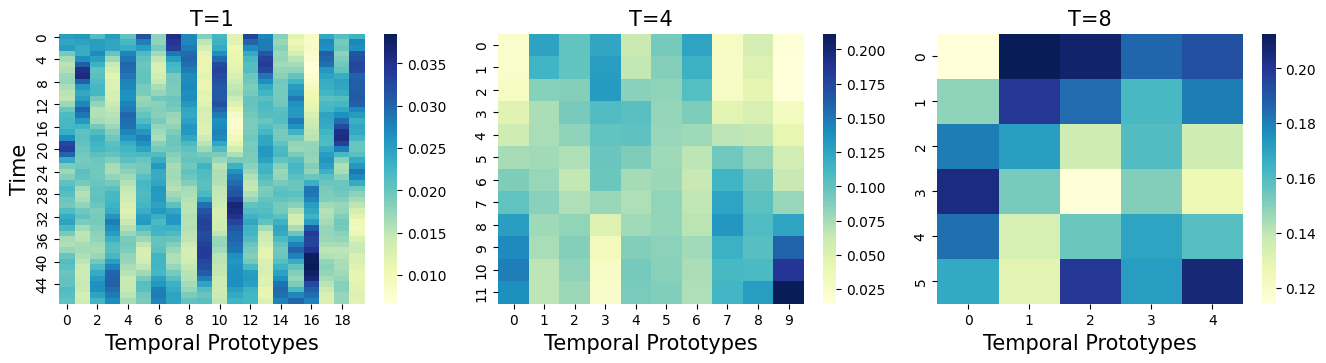

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

fig, axes = plt.subplots(1, 3)
fig.set_figwidth(14)
fig.set_figheight(3)
time_windows = [1, 4, 8]
for i in range(3):
    # img = axes[i].imshow(multi_attn[i][idx].detach().numpy().T, aspect="auto")
    sns.heatmap(multi_attn[i][idx].detach().numpy().T, ax=axes[i], cmap="YlGnBu", cbar=True)
    axes[i].set_title(f"T={time_windows[i]}", fontsize=15)
    if i == 0:
        axes[i].set_ylabel("Time", fontsize=15)
    axes[i].set_xlabel("Temporal Prototypes", fontsize=15)

plt.subplots_adjust(
    top=0.95, bottom=0.05, left=0.05,
    right=0.95,
    wspace=0.15, hspace=0.1)

# divider = make_axes_locatable(axes[2])
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(img, cax=cax, orientation='vertical')
fig.savefig("attention.pdf", format="pdf", bbox_inches="tight")

/tmp/ipykernel_2987862/3630066438.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(multi_attn[1][idx]
/tmp/ipykernel_2987862/3630066438.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(1, 11), fontsize=14)
/tmp/ipykernel_2987862/3630066438.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(multi_attn[1][idx]
/tmp/ipykernel_2987862/3630066438.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.arange(1, 11), fontsize=14)
/tmp/ipykernel_2987862/3630066438.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign 

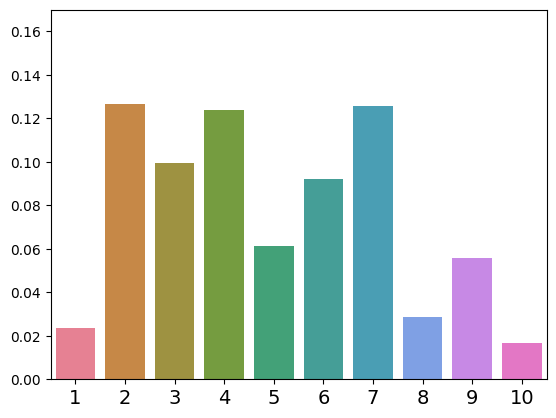

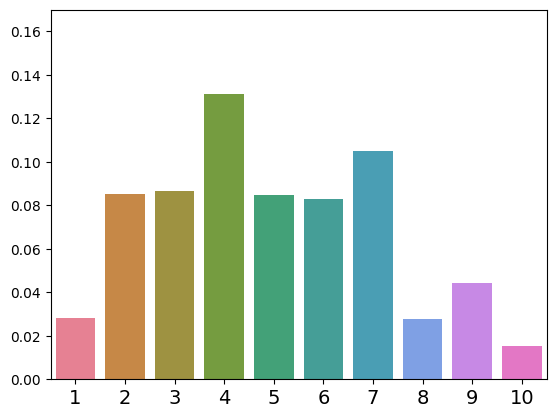

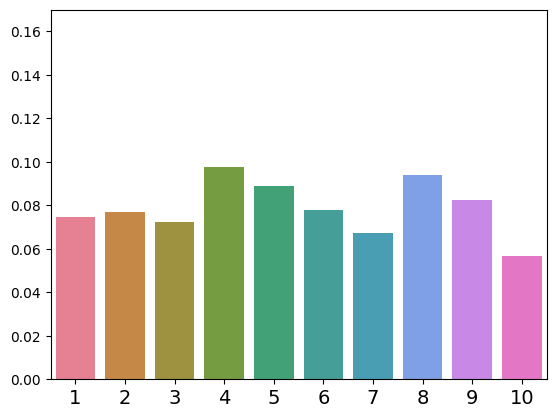

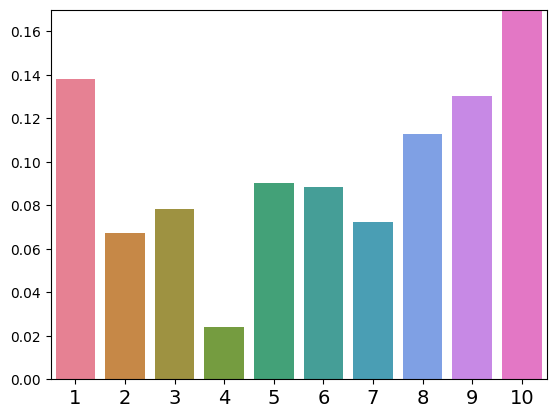

In [ ]:
idxs = [0, 2, 5, 11]
import numpy as np

import seaborn as sns
for cur_i in idxs:
    fig, ax = plt.subplots(1, 1)
    sns.barplot(multi_attn[1][idx]
                [:, cur_i].detach().numpy(), palette="husl", 
                ax=ax)
    ax.set_xticklabels(np.arange(1, 11), fontsize=14)
    ax.set_ylim(0, 0.17)